**классификатор LSTM**

Евгений Борисов <esborisov@sevsu.ru>

---

In [1]:
# печатать выход каждой строки ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
import torch.nn as nn

## данные

In [4]:
n_samples = 100 # количество примеров

seq_len = 3 # длина последовательности
input_dim = 8 # размер одного элемента последовательности

hid_dim = 32 # размер реккурентного слоя
output_dim = 2 # размер выхода

In [5]:
x = torch.rand( size=(n_samples,seq_len,input_dim) ) # генерируем случайные последовательности
y = torch.randint( high=output_dim, size=(n_samples,) ) # случайные метки примеров 
y = torch.nn.functional.one_hot(y).to(torch.float32) # преобразуем номер класса в OHE вектор {0,1}

In [6]:
x.shape
x[:2,:]

y.shape
y[:2,:]

torch.Size([100, 3, 8])

tensor([[[0.0565, 0.8230, 0.9320, 0.0728, 0.1631, 0.1343, 0.7680, 0.4023],
         [0.2232, 0.8446, 0.9864, 0.4431, 0.8772, 0.4613, 0.6495, 0.1059],
         [0.8396, 0.0918, 0.7007, 0.7172, 0.6160, 0.8138, 0.8104, 0.8269]],

        [[0.1783, 0.0356, 0.3866, 0.9489, 0.3597, 0.3573, 0.0629, 0.9113],
         [0.7922, 0.0375, 0.8866, 0.6143, 0.1483, 0.8397, 0.7073, 0.3190],
         [0.2031, 0.5407, 0.4275, 0.4774, 0.0877, 0.2380, 0.2240, 0.5412]]])

torch.Size([100, 2])

tensor([[1., 0.],
        [1., 0.]])

## строим модель

![lstm](http://mechanoid.su/content/neural-net-lstm.html/pix/lstm.png)

In [7]:
# https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091

class CustomLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz
        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.init_weights()
                
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
         
    def forward(self, x, init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device), 
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states
         
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.W + h_t @ self.U + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [8]:
class Model(nn.Module):
    def __init__(self, input_dim=input_dim, hid_dim=hid_dim, output_dim=2):
        super().__init__()
        self.rnn = CustomLSTM( input_sz=input_dim, hidden_sz=hid_dim)
        self.linear = nn.Linear(hid_dim, output_dim) # выходной (линейный) слой
        
    def forward(self,x):
        _, (hidden, _) = self.rnn(x) # обрабатываем входную последовательность
        hidden = hidden.squeeze(0) # прекомпоновка тензора, сокращаем размерность
        out = self.linear(hidden) # считаем выход сети
        return out 

In [9]:
model = Model()
model

Model(
  (rnn): CustomLSTM()
  (linear): Linear(in_features=32, out_features=2, bias=True)
)

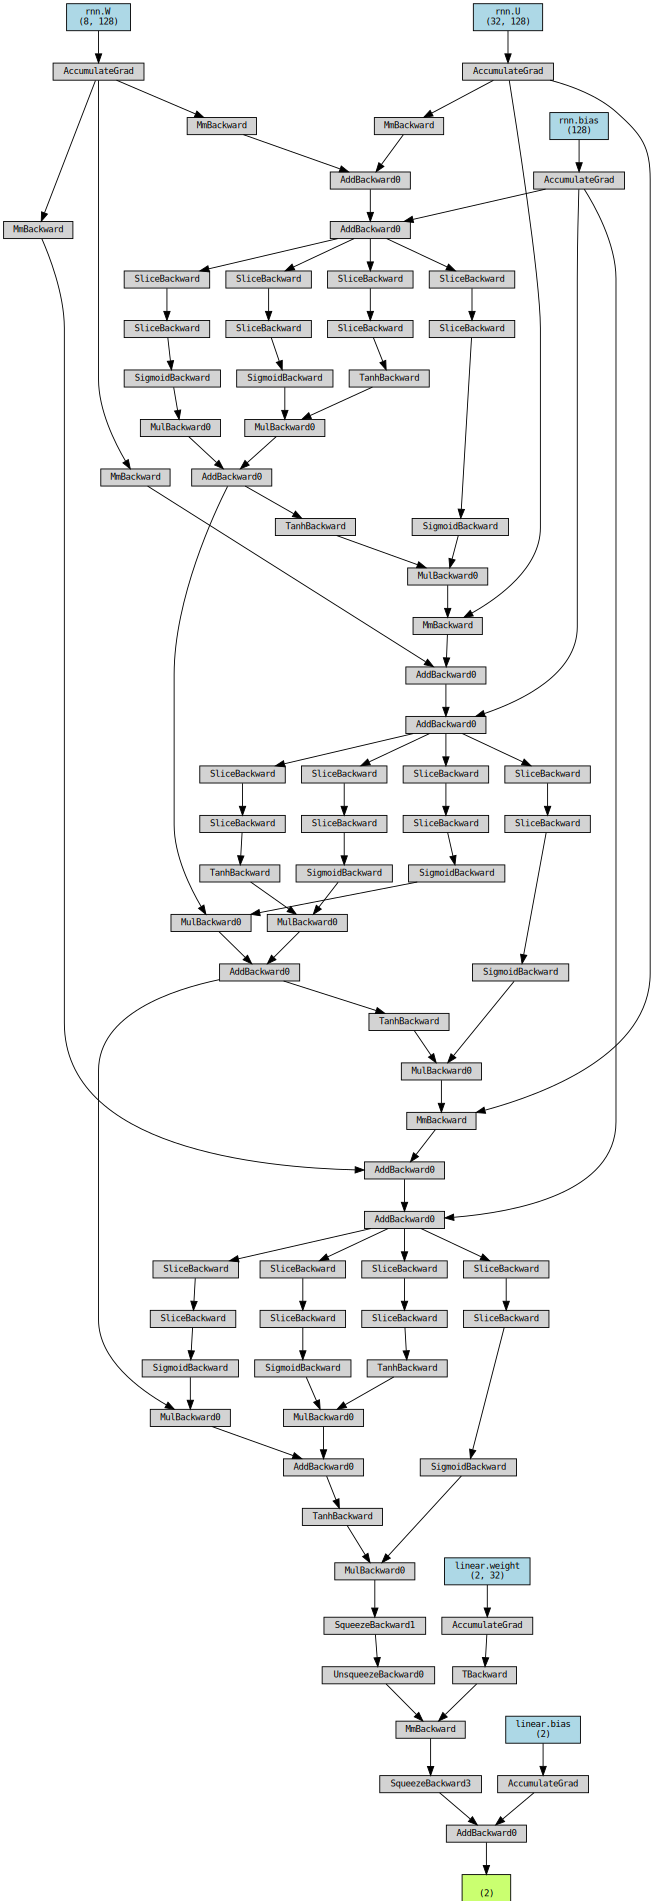

In [15]:
from torchviz import make_dot

z = torch.zeros( size=(1,seq_len,input_dim), dtype=torch.float, requires_grad=False)
out = model(z)
graph = make_dot( out, params=dict(list(model.named_parameters())) )  
# graph.render('lstm_torchviz', format='png')
graph

In [17]:
# import hiddenlayer as hl
# hl.build_graph(model, z, transforms=[ hl.transforms.Prune('Constant') ])

## обучаем модель

In [12]:
loss_function =  nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [13]:
epochs = 100
hist = []
for i in range(epochs):
    optimizer.zero_grad() # обнуляем значения градиента
    out = model(x) # вычисляем выход, прямой проход
    loss = loss_function(out,y) # вычисляем значение потери
    loss.backward() # вычисляем значения градиента потери, обратный проход
    optimizer.step() # изменяем значения весов модели
    if((i%50)==1): print(f'epoch: {i:3} loss: {loss.item():10.8f}')
    hist.append( loss.item() ) # сохраняем текущее значение потери

# print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.63479888
epoch:  51 loss: 0.24886051


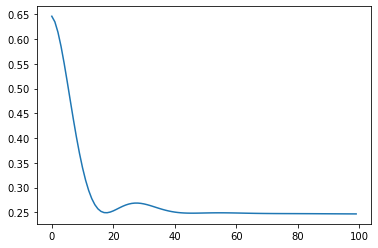

In [14]:
# изменение значения потери в процессе обучения
plt.plot(hist)